In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys, os
modelPath = os.getcwd()
sys.path.append(modelPath)
import model
import scipy
import msmtools
from joblib import dump, load

In [4]:
fname = 'tMat_LI204601_P_40_Oct04-2023pc10u2AllWells'

In [5]:
tMat = load(fname+'.joblib')
tMat = np.array(tMat, dtype=np.float64)
print("Shape of the transition matrix is: ",tMat.shape)

Shape of the transition matrix is:  (200, 200)


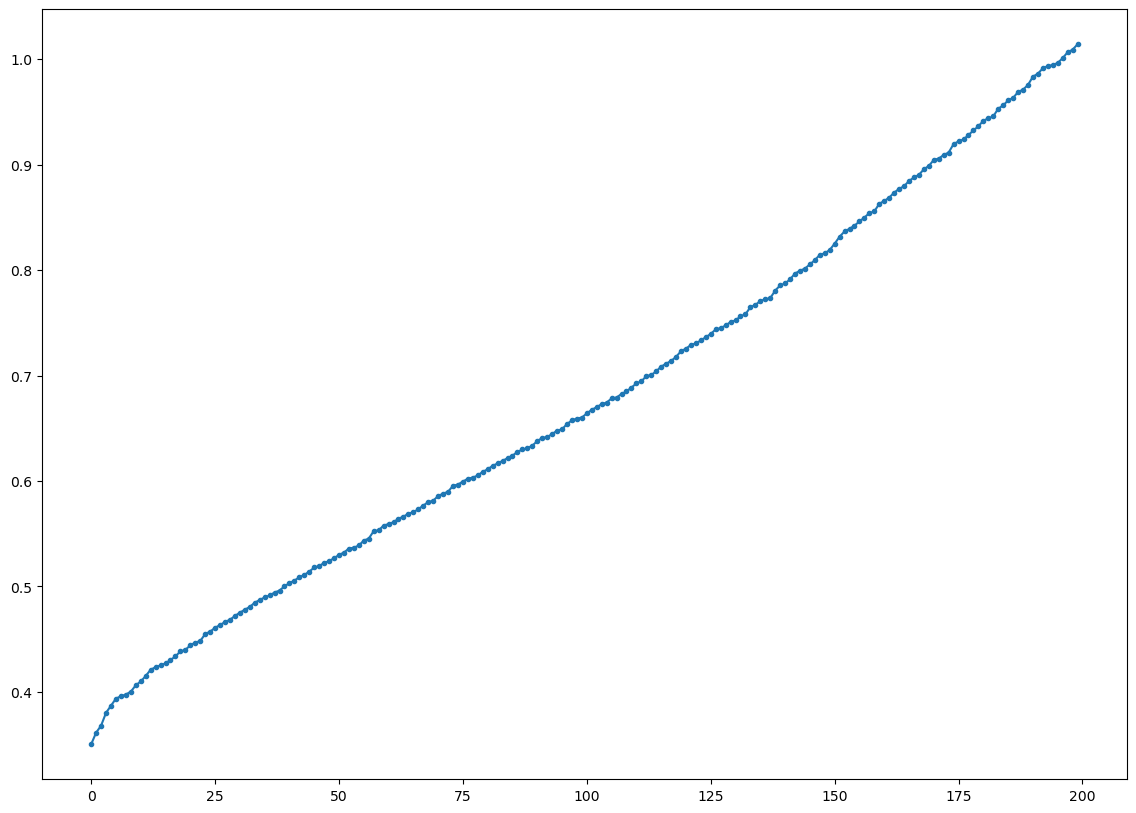

In [6]:
w, v = model.get_H_eigs(tMat)
fig, ax = plt.subplots(figsize = (14, 10))
ax.plot(w, marker ='o', markersize = 3) # 2nd Elbow --> ncomp
plt.show()

In [7]:
ncomp = 15
vkin = model.get_motifs(v, ncomp, w = w)

UMAPing eigen vectors of transition matrix

In [8]:
x_clusters = model.get_landscape_coords_umap(vkin)
#model.plot_eig(v, x_clusters, 5)

In [19]:
nstates = 7 # Number of Macrostates
stateSet = model.get_kineticstates(vkin, nstates, pcut_final = .068)

Clustering starts with the initial number of states =  7
[0.005 0.005 0.01  0.02  0.14  0.145 0.675]
7 states initial, 3 good states
[0.005 0.01  0.02  0.085 0.085 0.13  0.255 0.41 ]
8 states initial, 5 good states
[0.005 0.005 0.02  0.055 0.09  0.09  0.17  0.255 0.31 ]
9 states initial, 5 good states
[0.005 0.005 0.01  0.02  0.035 0.08  0.09  0.22  0.23  0.305]
10 states initial, 5 good states
[0.005 0.005 0.01  0.02  0.035 0.085 0.09  0.105 0.165 0.22  0.26 ]
11 states initial, 6 good states
[0.005 0.005 0.01  0.02  0.035 0.07  0.085 0.09  0.095 0.165 0.175 0.245]
12 states initial, 7 good states
pcut:  0.07 states_plow:  [ 4  6  7  8 11]


/home/exacloud/gscratch/ZuckermanLab/jalim/stateLandscape_tMat/model.py:198: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


[[4.38111687 3.99513006]
 [9.26544189 6.23987389]
 [3.96116996 0.96446061]
 [6.73077774 7.02081585]
 [8.26387405 4.92291451]
 [2.94457483 0.82574195]
 [6.14279795 2.53974557]]


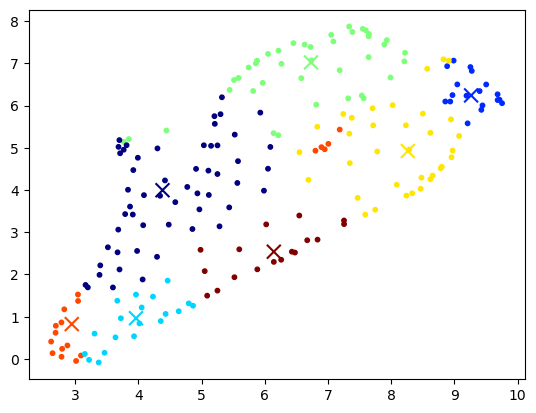

In [14]:
# plot all clustered embedded trajectories: "Microstates"
plt.scatter(x_clusters[:, 0], x_clusters[:, 1], s = 10, c = stateSet, cmap = plt.cm.jet)
nstates = np.unique(stateSet).size
n_states = nstates
state_centers = np.zeros((n_states, 2))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers[i, :] = np.median(x_clusters[indstate, :], axis = 0)

# Show state centers: "Macrostates"    
plt.scatter(state_centers[:, 0], state_centers[:, 1], s = 100, c = np.unique(stateSet),
            marker = 'x', cmap = plt.cm.jet)
import string
state_labels = np.array(list(string.ascii_uppercase))[0:nstates]
print(state_centers)

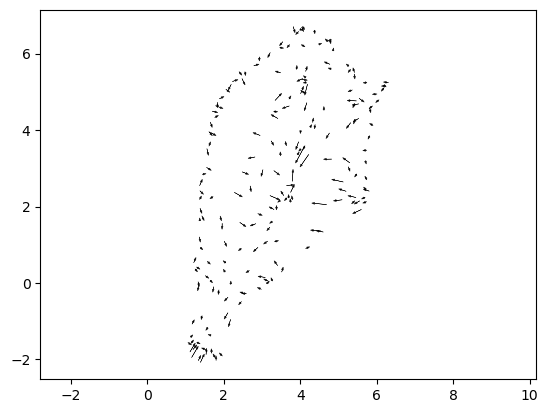

In [45]:
dx_clusters = model.get_avdx_clusters(x_clusters, tMat)
model.plot_dx_arrows(x_clusters, dx_clusters)
#cid = 100
#print(f'basis: {x_clusters[0, 0]:2f}, {x_clusters[0, 1]:2f} target {x_clusters[cid, 0]:2f}, {x_clusters[cid, 1]:2f}')

In [30]:
indSource = np.where(stateSet == 3)[0]
indTargets = np.where(stateSet == 5)[0]

In [31]:
%%capture
q = model.get_committor(tMat,indTargets, indSource, conv=1.e-5)
pSS = model.get_steady_state_matrixpowers(tMat, conv=1.e-6)

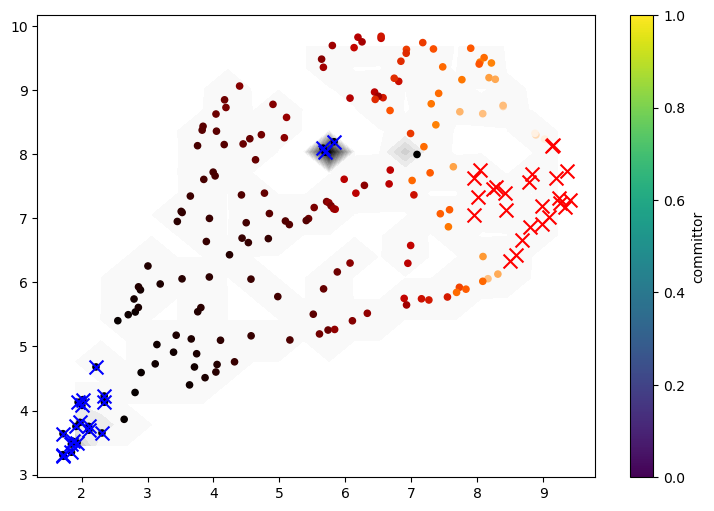

In [32]:
plt.figure(figsize = (9, 6))
prob, xedges1, yedges1 = np.histogram2d(x_clusters[:, 0], x_clusters[:, 1], bins=20, weights=pSS)
levels = np.linspace(np.min(prob[prob > 0]), np.max(prob), 20)
#prob1=scipy.ndimage.gaussian_filter(prob1,sigma=sml)
xx, yy = np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1], .5*yedges1[1:]+.5*yedges1[0:-1])
plt.contourf(xx, yy, prob.T, levels=levels, cmap=plt.cm.gray_r, alpha=1.0)
plt.scatter(x_clusters[:, 0], x_clusters[:, 1], s=20, c=q, cmap=plt.cm.gist_heat, marker='o',
            vmin=0., vmax=1.)
plt.scatter(x_clusters[indSource, 0], x_clusters[indSource, 1], s=100, c='blue', marker='x')
plt.scatter(x_clusters[indTargets, 0], x_clusters[indTargets, 1], s=100, c='red', marker='x')
cbar = plt.colorbar()
cbar.set_label('committor')
plt.show()

In [33]:
# coarse grained
Tmatrix_CG = np.zeros((nstates, nstates))
for istate in range(nstates):
    i_microlist = np.where(stateSet == istate)[0]
    for jstate in range(nstates):
        j_microlist = np.where(stateSet == jstate)[0]
        ij_CG = 0.
        for i in i_microlist:
            for j in j_microlist:
                ij_CG = ij_CG + tMat[i, j]
        Tmatrix_CG[istate, jstate] = ij_CG

for istate in range(nstates):
    Tmatrix_CG[istate, :] = Tmatrix_CG[istate, :]/np.sum(Tmatrix_CG[istate, :])

/tmp/ipykernel_34829/26314738.py:21: RuntimeWarning: invalid value encountered in divide
  vdist1 = np.divide(vdist1, norm1)


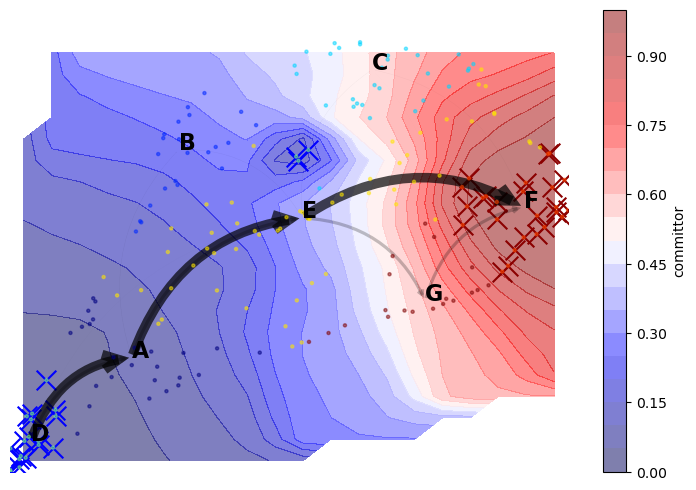

In [34]:
plt.figure(figsize = (9, 6))
stateA = np.unique(stateSet[indSource])
stateB = np.unique(stateSet[indTargets])
nbins = 20; sml = 1
rad = .3
mscale = 40.
arrowstyle = '<-'
lws = 10.
sh = 2
xmin = np.min(x_clusters[:, 0])
xmax = np.max(x_clusters[:, 0])
ymin = np.min(x_clusters[:, 1])
ymax = np.max(x_clusters[:, 1])
indNotTargets = np.setdiff1d(range(tMat.shape[0]), indTargets)
indNotSource = np.setdiff1d(range(tMat.shape[0]), indSource)
vdist1, xedges1, yedges1 = np.histogram2d(x_clusters[:, 0], x_clusters[:, 1], bins=nbins,
                                          weights=q.flatten())
vdist1 = scipy.ndimage.gaussian_filter(vdist1, sigma=sml)
norm1, xedges1, yedges1 = np.histogram2d(x_clusters[:, 0], x_clusters[:, 1], bins=[xedges1, yedges1])
norm1 = scipy.ndimage.gaussian_filter(norm1, sigma=sml)
vdist1 = np.divide(vdist1, norm1)
indnan = np.where(np.isnan(vdist1))
indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
xedges1c = .5*(xedges1[1:] + xedges1[0:-1])
yedges1c = .5*(yedges1[1:] + yedges1[0:-1])
xx1, yy1 = np.meshgrid(xedges1c, yedges1c)
levels = np.linspace(0, 1, 21) #np.min(vdist1[indgood]),np.max(vdist1[indgood]),20)
#cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.seismic, levels=levels, alpha=0.5)
cs = plt.contourf(xx1, yy1, vdist1.T, cmap=plt.cm.seismic, levels=levels, alpha=0.5)
cbar = plt.colorbar(cs)
cbar.set_label('committor')
plt.scatter(x_clusters[indTargets, 0], x_clusters[indTargets, 1], s=200, c='darkred', marker='x')
plt.scatter(x_clusters[indSource, 0], x_clusters[indSource, 1], s=200, c='blue', marker='x')
tpt = msmtools.flux.tpt(Tmatrix_CG, stateA, stateB)
pathways = tpt.pathways()
paths = pathways[0]
capacities = pathways[1]
ax = plt.gca()
for ipath in range(-1, -len(paths)-1, -1):
    statepath = paths[ipath]
    colorpath = capacities[ipath]/np.sum(capacities)
    for ipath in range(statepath.size-1):
        k = statepath[ipath]
        j = statepath[ipath+1]
        #note j and k flipped because drawing arrow at tail
        arrow = matplotlib.patches.FancyArrowPatch((state_centers[j, 0], state_centers[j, 1]), 
                                                   (state_centers[k,0], state_centers[k,1]),
                                                   shrinkA=sh, shrinkB=sh, mutation_scale=mscale*colorpath,
                                                   color='black', 
                                                   arrowstyle=arrowstyle, 
                                                   connectionstyle='arc3,rad='+str(rad), 
                                                   lw=lws*colorpath, joinstyle='miter', capstyle='butt', 
                                                   alpha=colorpath) 
        ax.add_patch(arrow)
for j in range(n_states):
    scolor = tpt.committor[j] + .01
    #plt.scatter(state_centers[j,0],state_centers[j,1],s=commsize,c=plt.cm.gist_heat(scolor),alpha=0.3)
    plt.text(state_centers[j, 0], state_centers[j, 1], state_labels[j], color='black', 
             weight='bold', fontsize=16, ma='center')
plt.scatter(x_clusters[:, 0], x_clusters[:, 1], s=5, c=stateSet, cmap=plt.cm.jet, alpha=.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax + .5)
plt.axis('off')
fname_savefig = './stateLands/stLand'+fname[4:]
plt.savefig(fname_savefig+'.png')
plt.show()

In [ ]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    #import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [ ]:
stateA = np.unique(stateSet[indSource])
stateB = np.unique(stateSet[indTargets])

In [ ]:
print("Source state is = ",stateA)
print("Target state is = ",stateB)